In [1]:
%matplotlib inline

This script first perform ta extraction and use a random forest to select the features, unify the data using MinMaxScaler, and then input the remaining feature paralelly into a simple LSTM model with multihead attention.

In [2]:
import sys
import pandas as pd
import torch

sys.path.append('..')
from utils import add_STL
from data_feature_extraction.CoT_Dissa import extract_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Config for this model:
### extract and filter
nCorrTop: num of Corr filter size
nMICTop: num of MIC filter size
### STL decomposition
period
seasonal (>= 3 and odd)
### Ramdom forest
n_estimators = 100
random_state = 42
### datasplit
test_size
### training

num_epochs = 120

lr = 0.004

batch_size = 32

l = 32

pr = 5 (Length of predict)

Loss function 
### LTSM with positional encoder
hidden_dim = 128
output_dim = pr
num_layers = 2

In [3]:
df = extract_data(datasoursepath = '../data/GC=F_com_disagg.csv', finalextracteddatapath = '../data/GC=F_com_disagg_finalextracted.csv', nCorrTop=100, nMICTop= 70)

ouput file already exsist, just read this file


Extract OHLC from trend and fluctuation
Calculate MA and fluctuation for training data for OHLC. put all data as new columns, and interpolate all beginning data with future data.

In [4]:
df = add_STL(df, period=32, seasonal = 3)
# df

In [5]:
string_cols = df.select_dtypes(include=['object']).columns.tolist()
df.set_index('date', drop=True)
print(len(df.columns))
print(df.columns)

87
Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Market_and_Exchange_Names', 'Report_Date_as_YYYY-MM-DD',
       'CFTC_Market_Code', 'Open_Interest_All', 'Prod_Merc_Positions_Long_All',
       'Prod_Merc_Positions_Short_All', 'Swap_Positions_Long_All',
       'Swap__Positions_Short_All', 'Swap__Positions_Spread_All',
       'M_Money_Positions_Long_All', 'M_Money_Positions_Short_All',
       'M_Money_Positions_Spread_All', 'Other_Rept_Positions_Long_All',
       'Other_Rept_Positions_Short_All', 'Other_Rept_Positions_Spread_All',
       'NonRept_Positions_Long_All', 'NonRept_Positions_Short_All',
       'Change_in_Open_Interest_All', 'Change_in_Prod_Merc_Long_All',
       'Change_in_Prod_Merc_Short_All', 'Change_in_Swap_Long_All',
       'Change_in_Swap_Spread_All', 'Change_in_M_Money_Spread_All',
       'Change_in_Other_Rept_Long_All', 'Change_in_Other_Rept_Short_All',
       'Change_in_Other_Rept_Spread_All', 'Change_in_NonRept_Long_All',
       'Change

Select the features

In [6]:
from data_feature_selection.cot_dissag import select_feature
test_size = 0.05
df_selected = select_feature(df, test_size= test_size, m = 10)

trend: 0.9521523207336454
volume_vwap: 0.023740524088291182
Swap__Positions_Short_All: 0.009727854379578885
Open_Interest_All: 0.0038215858929292563
seasonal: 0.002387923460113875
Pct_of_OI_Swap_Short_All: 0.0010001976034949291
momentum_rsi: 0.000979270450755076
M_Money_Positions_Long_All: 0.0006340374177503973
trend_adx_neg: 0.0005450579804408378
trend_adx_pos: 0.00042139922601009544
NonRept_Positions_Short_All: 0.00030454177714281725
Other_Rept_Positions_Spread_All: 0.00030119673730909897
volume_nvi: 0.00029894235347502373
resid: 0.00024576471509507494
Traders_M_Money_Long_All: 0.00024174639529690996
Conc_Gross_LE_4_TDR_Long_All: 0.00021987775814732335
trend_macd: 0.00019927490379765216
Conc_Gross_LE_4_TDR_Short_All: 0.00015478884553561212
momentum_tsi: 0.00013537490680866395
Prod_Merc_Positions_Short_All: 0.00013010438446366425
M_Money_Positions_Short_All: 0.00012663976096481317
Pct_of_OI_M_Money_Long_All: 0.00012436780139473062
volume_mfi: 0.000105043583054231
Other_Rept_Positions_

Unifying all data using min max scaler

In [7]:

train_size = int((1 - test_size) * len(df_selected))  # Use first 80% of series as training data
# Apply the MinMaxScaler to the df_selected
train_df = df_selected.iloc[:train_size]
test_df = df_selected
print(train_df.columns)
print(test_df.describe())
print(test_df.head(20))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'trend',
       'volume_vwap', 'Swap__Positions_Short_All', 'Open_Interest_All',
       'seasonal', 'Pct_of_OI_Swap_Short_All', 'momentum_rsi',
       'M_Money_Positions_Long_All', 'trend_adx_neg', 'trend_adx_pos',
       'NonRept_Positions_Short_All', 'Other_Rept_Positions_Spread_All',
       'volume_nvi', 'resid', 'Traders_M_Money_Long_All'],
      dtype='object')
              Open         High          Low        Close    Adj Close  \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean   1467.766889  1474.796201  1460.851316  1467.858747  1467.858747   
std     281.711685   283.659999   279.895320   281.807506   281.807506   
min    1053.699951  1062.000000  1046.199951  1050.800049  1050.800049   
25%    1241.450012  1247.000000  1236.950012  1242.250000  1242.250000   
50%    1320.300049  1324.400024  1315.500000  1320.400024  1320.400024   
75%    1772.750000  1782.500000  1765.099976  1772.

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

def create_dataset(scaler: MinMaxScaler, df: pd.DataFrame, l, pr):
    """
    For train: Create dataset just for model training. It should be large in whole dataset.
    It will firstly do scaling on all cols (over whole input dataset), so make sure there is no string columns.
    For test: create test dataset. The set have lookback period and future date, 
    for the testing data should not contain future data, you need to  May be need to calculate rolling minmax for each input:
    it should keep moving and calculate all using.
    """
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    X, Y = [], []
    for i in range(len(df)-l-pr+1):
        X.append(df.iloc[i:i+l].values)  # Get the values for l days
        Y.append(df.iloc[i+l:i+l+pr]['Close'].values)  # Get the closing price for the 16th day
    return np.array(X), np.array(Y), scaler




In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 24
# Split the data into training and test sets


# Create the dataset
l = 64
pr = 8

# Create the dataset
train_X, train_Y, scaler = create_dataset(scaler,train_df, l, pr)
test_X, test_Y, scaler = create_dataset(scaler,test_df, l, pr)
test_X, test_Y= test_X[len(train_Y):], test_Y[len(train_Y):]
 
# Create TensorDatasets
train_data = TensorDataset(torch.from_numpy(train_X).to(torch.float32), torch.from_numpy(train_Y).to(torch.float32))
test_data = TensorDataset(torch.from_numpy(test_X).to(torch.float32), torch.from_numpy(test_Y).to(torch.float32))
# Create DataLoaders
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)



Train

In [10]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs, device):
    print("model:", model)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            # print("Output:", outputs)
            
            # print("Shape of outputs", outputs.shape)
            # print("Shape of labels:", labels.shape)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {running_loss/len(train_dataloader)}')

    print('Finished Training')
    return model

def test_model(model, test_dataloader, criterion, device):
    model.eval()
    with torch.no_grad():
        tot_loss = 0
        trend_correct = 0  # Counter for correct trend predictions

        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            # print("Output:", outputs)
            
            loss = criterion(outputs, labels)

            tot_loss += loss.item()



        print(f'Evaluation on test data:  \
              Total loss: {tot_loss} \
                  ')



In [11]:
from models.LSTMWithAttention import StockPredictor3
model = StockPredictor3(input_dim = train_df.shape[1], hidden_dim = 128, num_layers = 1, pr = pr, output_dim = 1, dropout_prob = 0.2, num_heads = 2).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.MSELoss()
num_epochs = 60
train_model(model, train_loader, criterion = criterion, optimizer = optimiser, num_epochs = num_epochs, device = device)
test_model(model, test_dataloader = test_loader, criterion = criterion,device=device)


model: StockPredictor3(
  (lstm): LSTM(21, 128, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=8, bias=True)
)
Epoch 0, Loss: 0.012354732620145154
Epoch 10, Loss: 0.007668963315233629
Epoch 20, Loss: 0.0030998358501085972
Epoch 30, Loss: 0.0019110894980891
Epoch 40, Loss: 0.003493882715385711
Epoch 50, Loss: 0.004154814307738612
Finished Training
Evaluation on test data:                Total loss: 0.15166370011866093                   


Evaluation &
Accuracy

pred:  (120, 8)
real_price [0.8213250149370546, 0.8202258087417813, 0.8232237103570326, 0.8441091160069356, 0.8669931227336725, 0.8609973195031699, 0.8558008835124438, 0.8530029151958334, 0.8706904859318438, 0.8749875270410092, 0.8756869886239294, 0.8824822810791373, 0.8897771018186245, 0.8776855897007634, 0.8771859394315549, 0.8714899751565495, 0.8780853343131163, 0.876386572191779, 0.8648946159999824, 0.8115319428515246, 0.8148295614373435, 0.8203257143986376, 0.8260218006585722, 0.8148295614373435, 0.8114320371946686, 0.8005396369289368, 0.8026381436626269, 0.7828519442079971, 0.7906465372016218, 0.7890476807371403, 0.781652832355868, 0.780653531817451, 0.7666633242796119, 0.7574698081201463, 0.7656640237411949, 0.7775557245453439, 0.7863494960924569, 0.7821524826250768, 0.7963425014766277, 0.7965424347752683, 0.7625662164690876, 0.7613669826320297, 0.7779554691576964, 0.8106325479699634, 0.8602977359353208, 0.8548015829740268, 0.8751873383547206, 0.867592678659737, 0.91835719480529

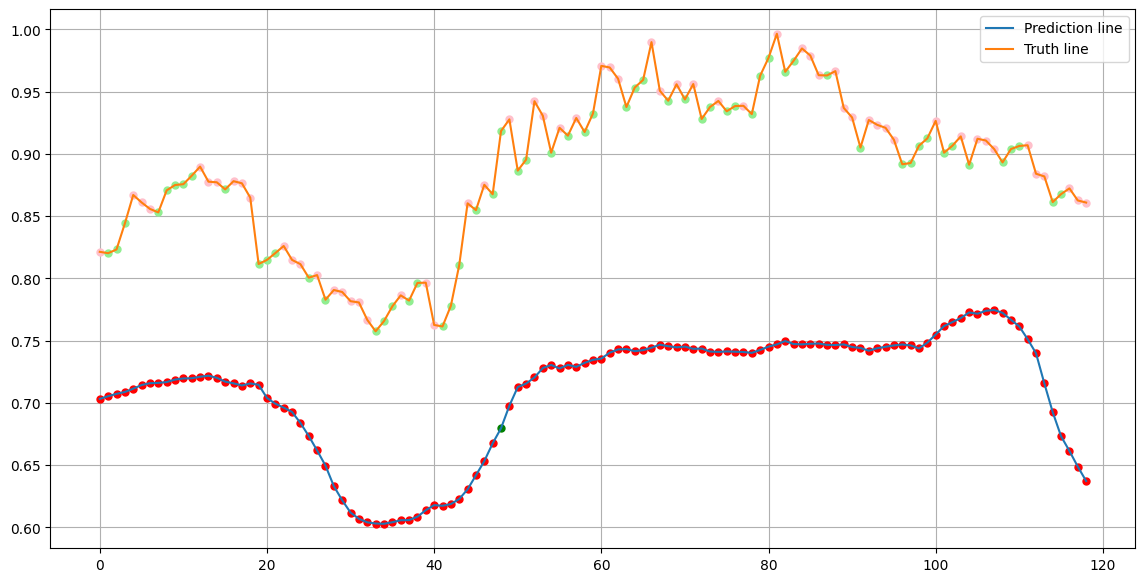

Accuracy for prediction length 2: 54.24%


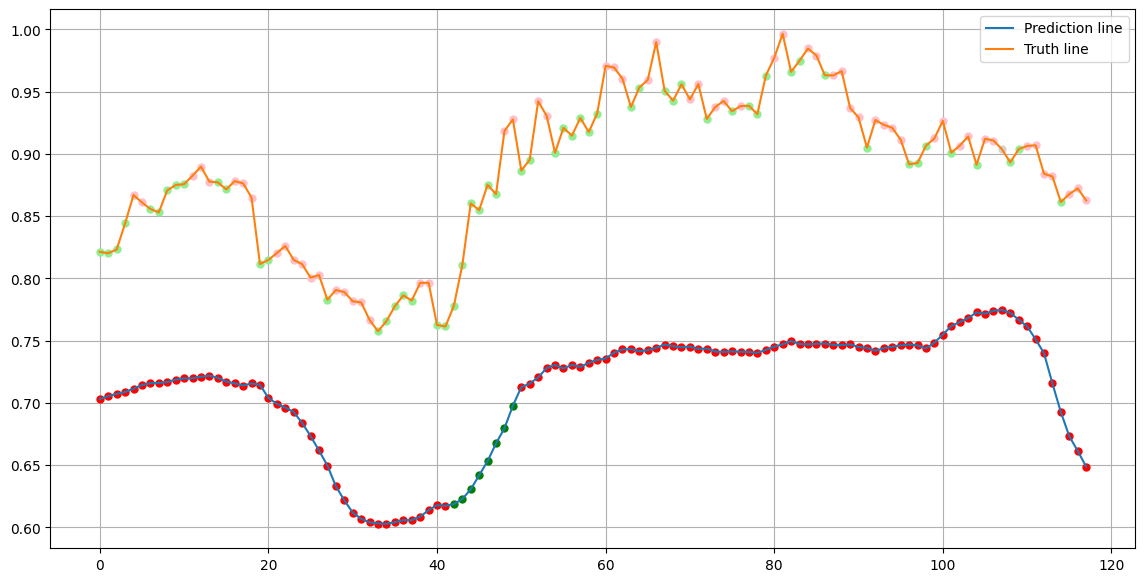

Accuracy for prediction length 3: 61.54%


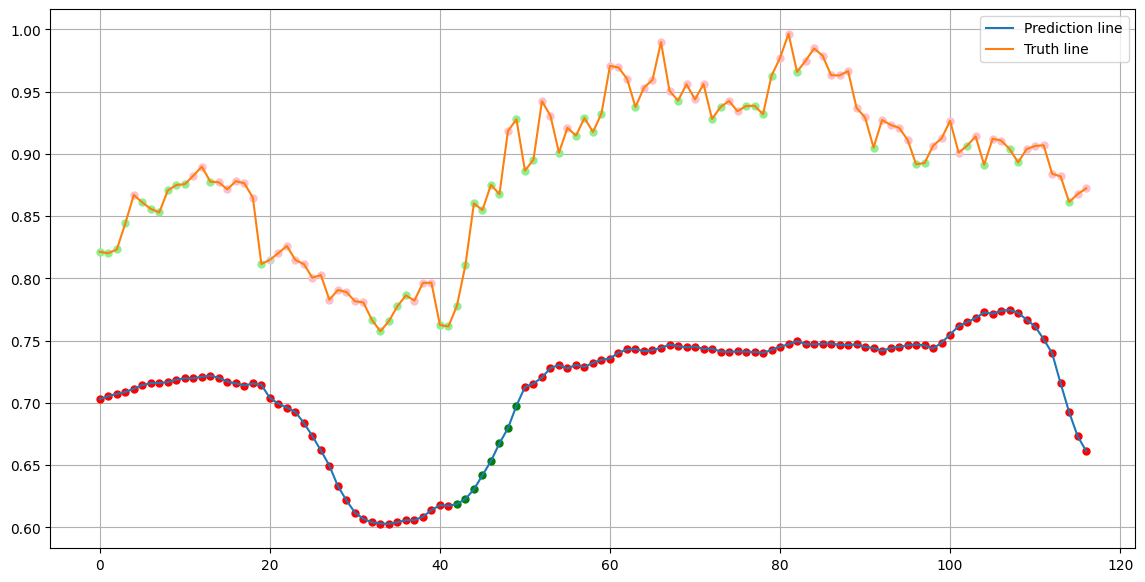

Accuracy for prediction length 4: 60.34%


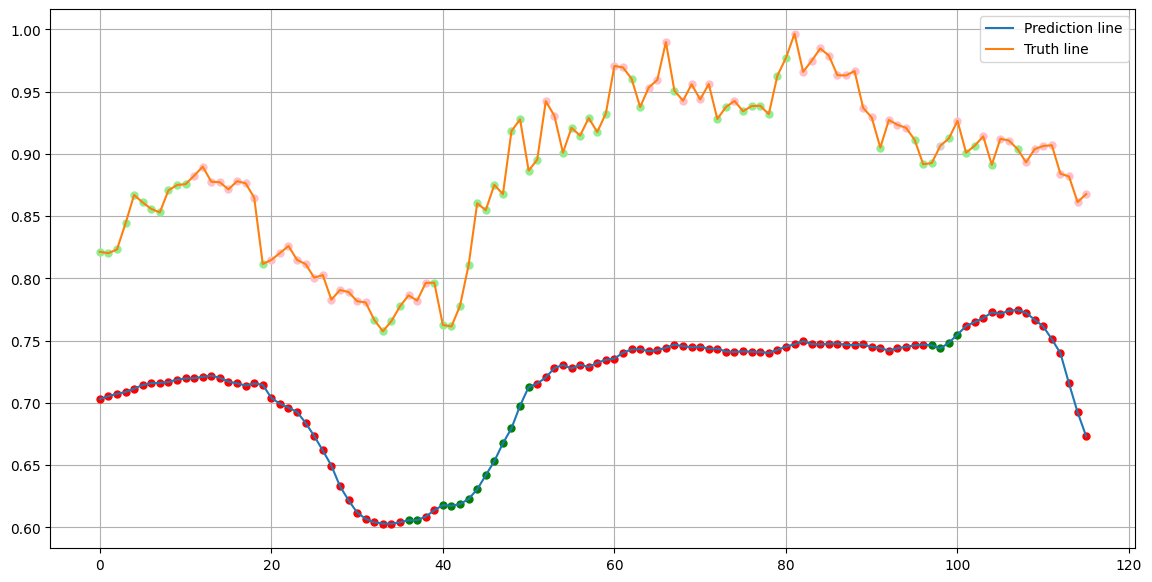

Accuracy for prediction length 5: 73.91%


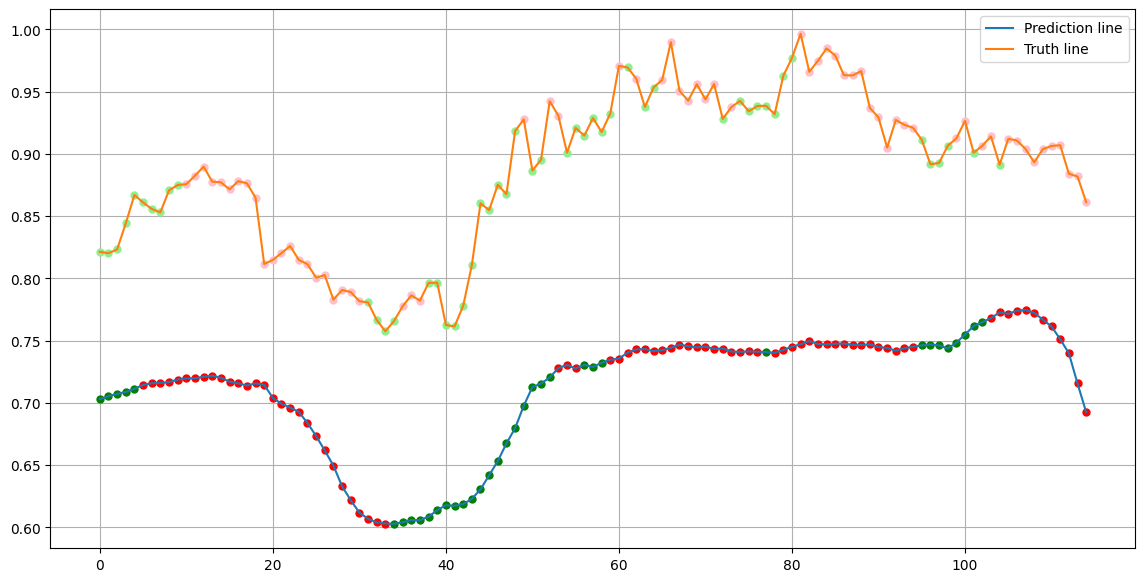

Accuracy for prediction length 6: 77.19%


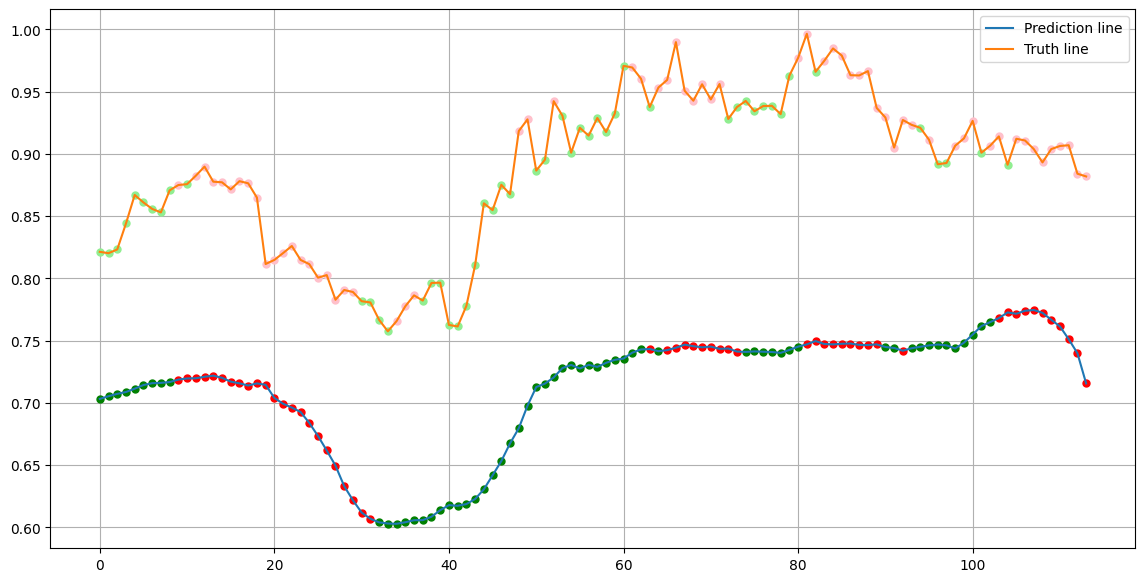

Accuracy for prediction length 7: 79.65%


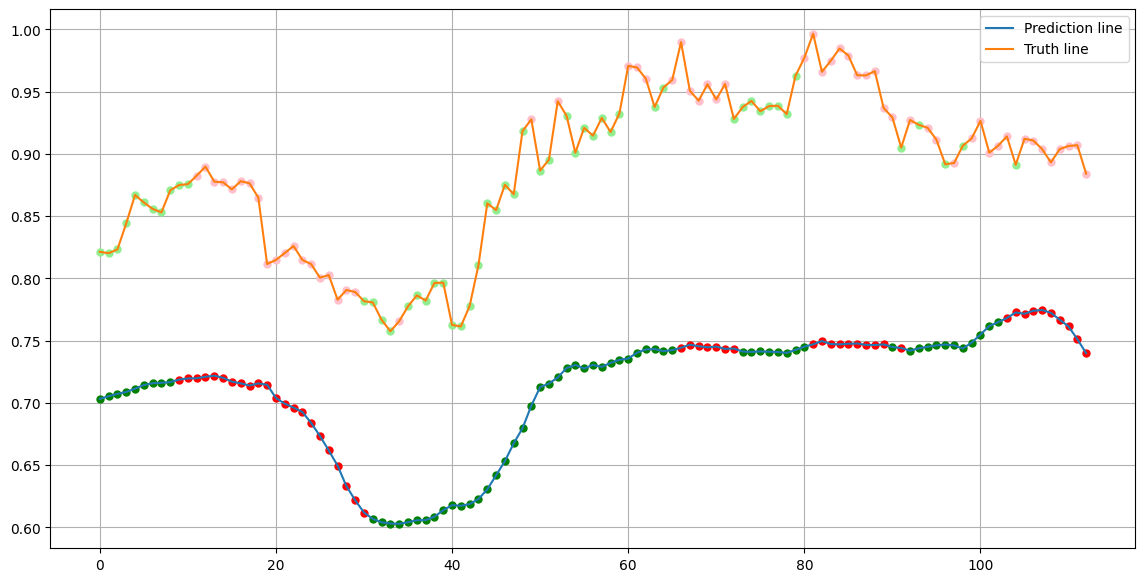

In [12]:
from utils import plot_predictions
plot_predictions(model, device = device,test_X = test_X,test_Y = test_Y)

In [13]:
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_Y_tensor = torch.tensor(test_Y, dtype=torch.float32)

with torch.no_grad():
    pred = []
    real_price = []
    for i in range(test_X_tensor.shape[0]):
        inputs = test_X_tensor[i].unsqueeze(0)  # Add batch dimension
        inputs = inputs.to(device)  # Don't forget to move your tensor to device
        
        outputs = model(inputs)
        
        
        outputs = outputs.squeeze().cpu().numpy()  # Remove batch dimension and move to cpu
        # print("output", outputs)
        # Calculate trends
        
        
        pred.append(outputs)
        real_price.append(test_Y[i][0])
        
pred = np.stack(pred, axis=0)
pred.shape

(120, 8)

In [14]:
pred_df = pd.DataFrame()
for i in range(1, pr):
    # print("Shape of np.array(pred[i:,0]):", np.array(pred[i:,0]).shape)
    # print("Shape of np.array(pred[:-i, i]):", np.array(pred[:-i, i].shape))
    temp_df = pd.DataFrame(np.append(np.array(pred[i:,0]) - np.array(pred[:-i, i]), np.nan))
    pred_df = pd.concat([pred_df, temp_df], ignore_index=True, axis=1)
pred_df = pred_df.fillna(method = 'ffill', axis = 1).fillna(method = 'ffill')
print(pred_df)


            0         1         2         3         4         5         6
0   -0.014743 -0.013858 -0.011538 -0.003795  0.003758  0.012028  0.011852
1   -0.015064 -0.014581 -0.010994 -0.002990  0.003182  0.010268  0.010514
2   -0.015435 -0.013827 -0.009893 -0.003303  0.001679  0.009190  0.010800
3   -0.014292 -0.012426 -0.009876 -0.004487  0.000908  0.009805  0.010369
4   -0.014042 -0.013626 -0.012221 -0.006420  0.000369  0.008294  0.008078
..        ...       ...       ...       ...       ...       ...       ...
115 -0.028782 -0.036302 -0.050225 -0.049678 -0.049678 -0.049678 -0.049678
116 -0.029378 -0.035610 -0.043321 -0.043321 -0.043321 -0.043321 -0.043321
117 -0.028090 -0.027839 -0.027839 -0.027839 -0.027839 -0.027839 -0.027839
118 -0.021531 -0.021531 -0.021531 -0.021531 -0.021531 -0.021531 -0.021531
119 -0.021531 -0.021531 -0.021531 -0.021531 -0.021531 -0.021531 -0.021531

[120 rows x 7 columns]


Starting backtest using backtrader

In [15]:
# get corresponding data from df
real_df = df[-len(test_Y):]
pred_df.index = real_df.index
# pd.merge(real_df, pred_df, left_on = real_df.index, right_on=pred_df.index)
bt_df = pd.concat([real_df, pred_df], axis = 1, join = 'inner')
# raname the numeric cols:
for i in range(1, pr):
    bt_df.rename(columns={bt_df.columns[-i]: "Col_" + str(pr - i) }, inplace = True)  

bt_df.to_csv("../data/Temp.csv")